# Case Study

## Purpose
 1. Evalute training dataset to fill in missing data in testing dataset
 1. Target is **value** column to indicate if a company ($9k) has a claim (100k)
 1. Expected profit per record = 9k - (value)*100k

# ## Imports & Setup

In [1]:
# imports & settings

import copy
import dill
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import mlflow  # for tracking
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

import shap

retune = True
mlflow.sklearn.autolog()
# set experiment
try:
    mlflow.set_experiment("casestudy")
except:
    mlflow.create_experiment("casestudy")

In [2]:
# Read in data

df = pd.read_csv("data/training.csv")

# ## Initial data exploration

In [3]:
df.head()

,city,website,employees,status,value
0,New York,http://www.ejmequities.com/,101-250,private,0
1,Las Vegas,http://www.digipath.com,11-50,public,0
2,Mountain View,http://www.videogram.com,1-10,private,0
3,Glen Allen,https://livingmatrix.com/,11-50,private,0
4,Houston,https://www.pegwin.io/contact,11-50,private,0


In [4]:
# Read in test data

df_test = pd.read_csv("data/testing.csv")
df_test.head()
df_test.describe(include="all")

,city,website,employees
count,2000,2000,2000
unique,409,2000,9
top,San Francisco,http://www.lendingstandard.com,11-50
freq,283,1,860


 Test data missing status column

In [5]:
# Data

df.describe(include="all")

,city,website,employees,status,value
count,2000,2000,2000,2000,2000.000000
unique,447,2000,9,3,NaN
top,San Francisco,http://www.ejmequities.com/,11-50,private,NaN
freq,268,1,883,1826,NaN
mean,NaN,NaN,NaN,NaN,0.100000
std,NaN,NaN,NaN,NaN,0.300075
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,0.000000


 Three columns in input, output is binary (0 or 1) and imbalanced with mostly 0
 There are too many city and website to use natively as categorical. Only employees
 there is ordering in amount of employees, so consider as ordinal fo later

In [6]:
# categorical vs numerical vs ordinal to start

categorical_vars = ["status"]  # consider city/website after
numerical_vars = []
ordinal_vars = ["employees"]
target = "value"

In [7]:
# Investigate initial vars
# as it has reasonable/smaller split

for v in categorical_vars + ordinal_vars:
    print(df.pivot_table("value", aggfunc="mean", index=v))

             value
status            
delisted  0.100000
private   0.102410
public    0.067164
               value
employees           
1-10        0.115942
10001+      0.041667
1001-5000   0.102041
101-250     0.083770
11-50       0.100793
251-500     0.080000
5001-10000  0.076923
501-1000    0.169492
51-100      0.086957


## Conclusion 1
 1. There may be some signal in status, but this is not available in test set
 1. Website is one to one, so difficult to use directly
 1. City is also sparse, but there are frequent data points that maybe we can group
 1. Employees sign is noisy  no clear trend

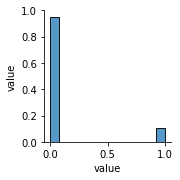

In [8]:
# Use pairplots to quickly see basic relationships for numerical

sns.pairplot(df)

In [9]:
# Examine records with claims

df_wclaims = df.loc[df["value"] > 0]
df_wclaims.head()

,city,website,employees,status,value
41,New York,http://www.timelooper.com,11-50,private,1
60,Los Angeles,https://edgemesh.com,1-10,private,1
63,Gainesville,https://www.foreveroceans.com/,11-50,private,1
65,San Francisco,http://getlocket.com,11-50,private,1
67,San Francisco,https://smartloop.ai,1-10,private,1


In [10]:
# Create validation dataset for tuning/checking later

from sklearn.model_selection import train_test_split

# use stratify to get same mean
X_train_train, X_train_valid = train_test_split(df, stratify=df["value"])

print(X_train_train.describe(include="all"))
print(X_train_valid.describe(include="all"))

                 city                           website employees   status  \
count            1500                              1500      1500     1500   
unique            377                              1500         9        3   
top     San Francisco  http://www.blackducksoftware.com     11-50  private   
freq              211                                 1       671     1361   
mean              NaN                               NaN       NaN      NaN   
std               NaN                               NaN       NaN      NaN   
min               NaN                               NaN       NaN      NaN   
25%               NaN                               NaN       NaN      NaN   
50%               NaN                               NaN       NaN      NaN   
75%               NaN                               NaN       NaN      NaN   
max               NaN                               NaN       NaN      NaN   

            value  
count   1500.0000  
unique        NaN  
top

# ## Naive model
 Using no variables

In [11]:
# naive model to start

naive_model = sum(df[target]) / df.shape[0]
print(naive_model)

naive_profit = df_test.shape[0] * (9000 - (naive_model) * 100000)
print(f"test set naive profit of {naive_profit}")

0.1
test set naive profit of -2000000.0


# ## Metrics for Comparison
 This is an imbalanced dataset with only two output values, but we can set price as
 a number, so still treat as a regression problem where we are seeking differentiaation
 use r2_score as a check to ensure selection is better than global mean

In [12]:
from sklearn.metrics import r2_score

predictions = np.full((X_train_valid.shape[0],), naive_model)

print(r2_score(X_train_valid[target], predictions))

# which is zero because we've only selected mean
# higher is better (max is 1)

0.0


# ## Support Functions

In [13]:
# define gini function for differentiatino
# https://www.kaggle.com/jpopham91/gini-scoring-simple-and-efficient
def gini_normalized(y_true, y_pred, sample_weight=None):
    # check and get number of samples
    assert (
        np.array(y_true).shape == np.array(y_pred).shape
    ), "y_true and y_pred need to have same shape"
    n_samples = np.array(y_true).shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    if sample_weight == None:
        sample_weight = np.ones(n_samples)

    arr = np.array([y_true, y_pred, sample_weight]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]  # true col sorted by true
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]  # true col sorted by pred

    true_order_wgts = arr[arr[:, 0].argsort()][::-1, 2]
    pred_order_wgts = arr[arr[:, 0].argsort()][::-1, 2]

    # get Lorenz curves
    L_true = np.cumsum(np.multiply(true_order, true_order_wgts)) / np.sum(
        np.dot(true_order, true_order_wgts)
    )
    L_pred = np.cumsum(np.multiply(pred_order, pred_order_wgts)) / np.sum(
        np.multiply(pred_order, pred_order_wgts)
    )
    L_ones = np.multiply(np.linspace(1 / n_samples, 1, n_samples), pred_order_wgts)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred / G_true


assert gini_normalized([1, 2], [1, 2]) == 1, "perfect matching should have gini of 1"

print(f"starting gini {gini_normalized(X_train_valid[target], predictions)}")

# higher is better (1 is max)

starting gini 0.022666666666666654


In [14]:
# Other functions


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    formula,
    weights=None,
    tweedie_powers=None,
):
    """
    Evaluate an estimator on train and test sets with different metrics
    Requires active run on mlflow and estimator with .predict method
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, auc, r2_score
    from functools import partial
    from sklearn.metrics import mean_tweedie_deviance

    mlflow.set_tag("run_id", mlflow.active_run().info.run_id)
    mlflow.log_params({"formula": formula})

    metrics = [
        # ("default score", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
        ("gini", gini_normalized),
        ("r2", r2_score),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = {}
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        if weights != None:
            y, _weights = df[target], df[weights]
        else:
            y, _weights = df[target], None

        if isinstance(estimator, tuple) and len(estimator) == 2:
            # Score the model consisting of the product of frequency and
            # severity models.
            est_freq, est_sev = estimator
            y_pred = est_freq.predict(X) * est_sev.predict(X)
        elif "h2o" in str(type(estimator)):
            y_pred = (
                estimator.predict(h2o.H2OFrame(X)).as_data_frame().to_numpy().ravel()
            )  # ensure 1D array
        else:
            y_pred = estimator.predict(X)

        for score_label, metric in metrics:

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res[score_label + "_" + subset_label] = score

    return res


def to_categorical(x):
    return x.astype("category")


def to_float(x):
    return x.astype(float)

# ## Try Gradient Boosting with more vars (i.e. city)

In [15]:
# find top cities

city_counts = df["city"].value_counts()

top_city = ["NA"] + list(
    city_counts[city_counts > 30].index
)  # 30 is somewhat arbitrary, tied to idea that ~30 needed for credibilty of a statistic

In [16]:
# build model

numeric_features = []
categorical_features = [
    "status",
]  # df is missing "status","city", "website" are too sparse
employee_feature = ["employees"]
city_feature = ["city"]
all_features = numeric_features + categorical_features + employee_feature + city_feature
# order matters

mlflow.end_run()
mlflow.start_run(run_name="sklearn_hgbm")

numeric_transformer = Pipeline(
    steps=[
        ("to_float", FunctionTransformer(func=to_float)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("to_categorical", FunctionTransformer(func=to_categorical)),
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

employee_transformer = Pipeline(
    steps=[
        (
            "ordinal",
            OrdinalEncoder(
                categories=[
                    [
                        "1-10",
                        "11-50",
                        "51-100",
                        "101-250",
                        "251-500",
                        "501-1000",
                        "1001-5000",
                        "5001-10000",
                        "10001+",
                    ]
                ],
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,
            ),
        ),
    ]
)

city_transformer = Pipeline(
    steps=[
        (
            "ordinal",
            OrdinalEncoder(
                categories=[top_city],
                handle_unknown="use_encoded_value",
                unknown_value=len(top_city),
            ),
        ),
    ]
)


# based on variable order
categorical_mask = (
    [False] * len(numeric_features)
    + [True] * len(categorical_features)
    + [True] * len(employee_feature)
    + [True] * len(city_feature)
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("emp", employee_transformer, employee_feature),
        ("city", city_transformer, city_feature),
    ],
    remainder="drop",
)


# tuning
if retune:
    gini_scorer = make_scorer(gini_normalized, greater_is_better=True)

    # use hyperopt package with to better search
    # https://github.com/hyperopt/hyperopt/wiki/FMin
    # use userdefined Gini, as it measures differentiation more
    def objective_gbr(params):
        "objective_gbr function for hyper opt, params is dict of params for mdl"
        mlflow.start_run(nested=True)
        parameters = {}
        for k in params:
            parameters[k] = params[k]
        mdl = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                (
                    "estimator",
                    HistGradientBoostingRegressor(
                        random_state=0,
                        **parameters,
                        categorical_features=categorical_mask,
                    ),
                ),
            ]
        )
        score = cross_val_score(
            mdl, df, df[target].squeeze(), scoring=gini_scorer, cv=5
        ).mean()
        print("Gini {:.3f} params {}".format(score, parameters))
        mlflow.end_run()
        return score

    # need to match estimator
    space = {
        # low # high # number of choices
        "learning_rate": hp.uniform("learning_rate", 0.1, 1),
        "max_depth": hp.quniform("max_depth", 2, 4, 2),
        "loss": "poisson",  # implies log-link, which is desired with non-negative data
    }

    best_params = fmin(fn=objective_gbr, space=space, algo=tpe.suggest, max_evals=5)

    for key in best_params.keys():
        if int(best_params[key]) == best_params[key]:
            best_params[key] = int(best_params[key])

    print("Hyperopt estimated optimum {}".format(best_params))

else:
    # ran earlier
    best_params = {
        "learning_rate": 0.6118176373029943,
        "max_depth": 2,
        "loss": "poisson",
    }

mdl = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "estimator",
            HistGradientBoostingRegressor(
                random_state=0, **best_params, categorical_features=categorical_mask
            ),
        ),
    ]
)
# reg = GradientBoostingRegressor(random_state=0)
mdl.fit(df[all_features], df[target].squeeze())

# log with validation
# log_w_validate(y_test, y_pred, formula)
res = score_estimator(
    mdl, X_train_train, X_train_valid, X_train_train, X_train_valid, target, ""
)

mlflow.log_metrics(res)
mlflow.set_tag("target", target)

# addition artifacts
# visualize a single tree
# Get a tree
# sub_tree_1 = reg.estimators_[0, 0]  # pull first 1 estimator, actual regressor vs array

# tree.plot_tree(sub_tree_1, feature_names=list(X_train.columns), filled=True, fontsize=7)

# plt.tight_layout()
# plt.savefig("tree_plot1.png", bbox_inches="tight")
# plt.show()

# mlflow.log_artifact("tree_plot1.png")

# save requirements
os.system("pipenv lock --keep-outdated -d -r > requirements.txt")
mlflow.log_artifact("requirements.txt")

# save categorical dict values
cat_dict = {}
for c in categorical_features + city_feature + employee_feature:
    cat_dict[c] = list(df[c].unique())

with open(f"cat_dict.pkl", "wb") as handle:
    dill.dump(cat_dict, handle, recurse=True)

mlflow.log_artifact(f"cat_dict.pkl")

os.remove(f"cat_dict.pkl")

mlflow.end_run()

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2022/06/25 19:51:58 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:51:58 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:51:58 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('cat', Pipeline(steps=[('to_categ

Gini -0.039 params {'learning_rate': 0.8959471450100245, 'loss': 'poisson', 'max_depth': 4.0}
 20%|██        | 1/5 [00:29<01:58, 29.69s/trial, best loss: -0.03893315549967994]

2022/06/25 19:52:28 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:52:28 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:52:28 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('cat', Pipeline(steps=[('to_categ

Gini -0.043 params {'learning_rate': 0.7058976560060025, 'loss': 'poisson', 'max_depth': 2.0}
 40%|████      | 2/5 [00:53<01:19, 26.34s/trial, best loss: -0.042686683960513526]

2022/06/25 19:52:52 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:52:52 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:52:52 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('cat', Pipeline(steps=[('to_categ

Gini -0.046 params {'learning_rate': 0.48398229260381864, 'loss': 'poisson', 'max_depth': 4.0}
 60%|██████    | 3/5 [01:19<00:51, 25.88s/trial, best loss: -0.045630902686441224]

2022/06/25 19:53:17 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:53:17 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:53:17 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('cat', Pipeline(steps=[('to_categ

Gini -0.030 params {'learning_rate': 0.4744542794267643, 'loss': 'poisson', 'max_depth': 2.0}
 80%|████████  | 4/5 [01:41<00:24, 24.48s/trial, best loss: -0.045630902686441224]

2022/06/25 19:53:40 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:53:40 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:53:40 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('cat', Pipeline(steps=[('to_categ

Gini -0.033 params {'learning_rate': 0.13480682197887278, 'loss': 'poisson', 'max_depth': 4.0}
100%|██████████| 5/5 [02:01<00:00, 24.37s/trial, best loss: -0.045630902686441224]

2022/06/25 19:54:00 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`
2022/06/25 19:54:00 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`
2022/06/25 19:54:00 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('cat', Pipeline(steps=[('to_categor


Hyperopt estimated optimum {'learning_rate': 0.48398229260381864, 'max_depth': 4}


## Explain model

In [17]:
explainer = shap.Explainer(mdl[-1])

# fix save expected value
if len(explainer.expected_value.shape) > 0:
    ev = explainer.expected_value[0]
    explainer.expected_value = ev

shap_obj = explainer(mdl[0].transform(df))


var = "status"

# shap_obj, requires column transformer in step position 0 ,
# categorical in position 1

# def update_shap_obj(shap_obj, X_train, encoder):

rename_list = [
    (
        1,  # pipeline order
        1,  # order of ordinalencoder
        categorical_features,  # column name
    ),
    (
        2,  # pipeline order
        0,  # order of ordinalencoder
        employee_feature,  # column name
    ),
    (
        3,  # pipeline order
        0,  # order of ordinalencoder
        city_feature,  # column name
    ),
]


shap_obj.feature_names = list(all_features)
shap_cat = copy.deepcopy(shap_obj)
shap_cat.data = np.array(shap_obj.data, dtype="object")
for name_tuple in rename_list:

    trans_idx = name_tuple[0]
    # ordinal_idx = name_tuple[1]
    cat = name_tuple[2]

    # categorical_names = list(df.select_dtypes(include=["object"]).columns)
    col_idx = list(np.where(np.isin(shap_obj.feature_names, cat))[0])

    # fix categorical names
    res_arr = (
        mdl[0]
        .transformers_[trans_idx][1][-1]
        .inverse_transform(pd.DataFrame(shap_cat.data[:, col_idx], columns=[cat]))
    )

    # update shap col
    for i, loc in enumerate(col_idx):
        shap_cat.data[:, loc] = res_arr[:, i]

# new_dtype = "object"
# res_arr.astype(
#     [(col, new_dtype) if d[0] in categorical_names else d for d in res_arr.dtype.descr]
# )

# col_idx = shap_obj.feature_names.index(var)
# ord_encode_idx = mdl[0].transformers_[1][2].index(var)

## Explainer plots
 overall plot

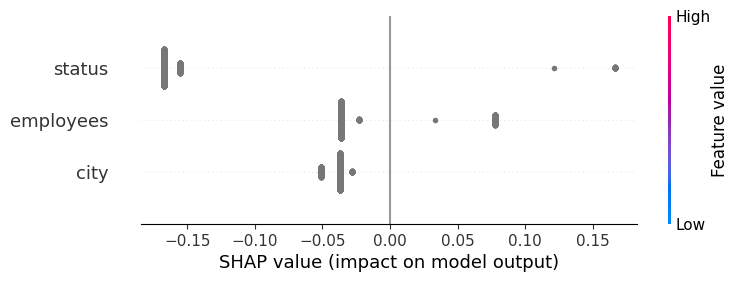

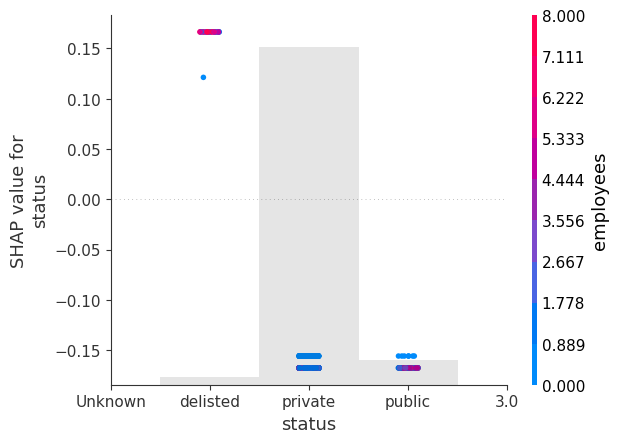

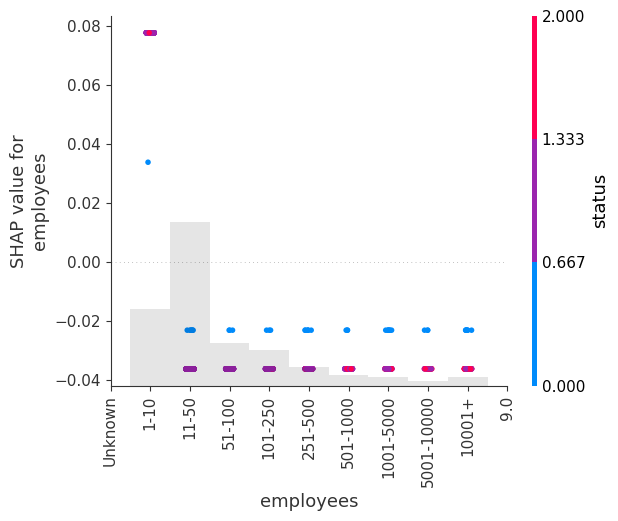

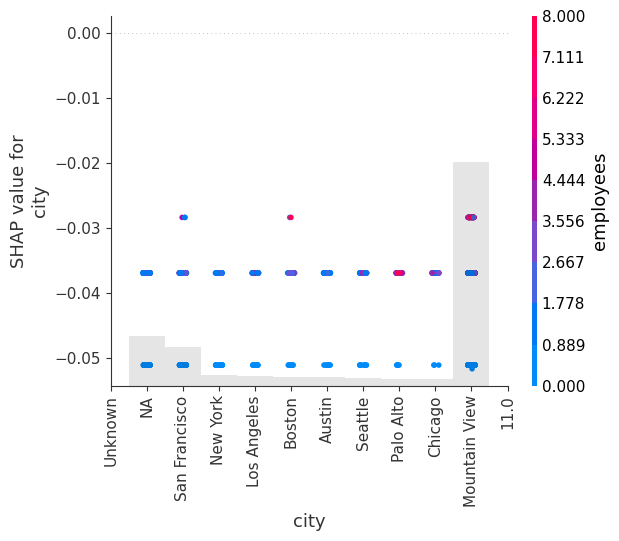

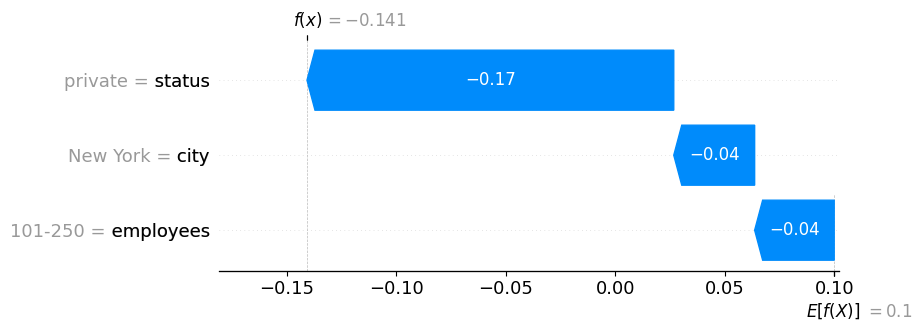

In [18]:
shap.plots.beeswarm(shap_cat)

# individual plots
for var in all_features:

    fig, ax = plt.subplots()

    shap.plots.scatter(shap_obj[:, var], ax=ax, show=False, color=shap_obj)

    # find which transformer has this feature
    trans_idx = 0
    for i, trans in enumerate(mdl[0].transformers_):
        if var in trans[-1]:
            trans_idx = i
            var_idx = trans[-1].index(var)

    # replace labels with orig
    if var not in numeric_features:
        # get integer labels
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        orig_list = ax.get_xticks()
        new_list = np.insert(
            mdl[0].transformers_[trans_idx][1][-1].categories_[var_idx],
            0,
            "Unknown",
        )

        for i in range(len(orig_list) - len(new_list)):
            new_list = np.append(new_list, orig_list[i + len(new_list)])

        ax.set_xticks(orig_list)
        if len(orig_list) > 5:
            ax.set_xticklabels(new_list, rotation=90)
        else:
            ax.set_xticklabels(new_list)

    plt.show()

shap.plots.waterfall(shap_cat[0])

## Conclusion 2
 For the training dataset, and assuming test dataset is similar
 1. status, especially status=delisted records, have greater chance of claim
 1. smallest employees have greater chance as well
 1. city is least predictive, overall
 1. test data is missing status, but can try to use website to see if delisted

## Pull Delisted Stock Data
 https://www.alphavantage.co/documentation/  for free API key
 pulled listing_status.csv from as of 2021
 https://www.alphavantage.co/query?function=LISTING_STATUS&date=2022-06-10&state=delisted&apikey=REPLACEME

# For Now, use GBM with Existing Vars

In [19]:
numeric_features = []
categorical_features = [
    # "status",
]  # df is missing "status","city", "website" are too sparse
employee_feature = ["employees"]
city_feature = ["city"]
all_features = numeric_features + categorical_features + employee_feature + city_feature
# order matters

mlflow.end_run()
mlflow.start_run(run_name="sklearn_hgbm")

numeric_transformer = Pipeline(
    steps=[
        ("to_float", FunctionTransformer(func=to_float)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("to_categorical", FunctionTransformer(func=to_categorical)),
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

employee_transformer = Pipeline(
    steps=[
        (
            "ordinal",
            OrdinalEncoder(
                categories=[
                    [
                        "1-10",
                        "11-50",
                        "51-100",
                        "101-250",
                        "251-500",
                        "501-1000",
                        "1001-5000",
                        "5001-10000",
                        "10001+",
                    ]
                ],
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,
            ),
        ),
    ]
)

city_transformer = Pipeline(
    steps=[
        (
            "ordinal",
            OrdinalEncoder(
                categories=[top_city],
                handle_unknown="use_encoded_value",
                unknown_value=len(top_city),
            ),
        ),
    ]
)


# based on variable order
categorical_mask = (
    [False] * len(numeric_features)
    + [True] * len(categorical_features)
    + [True] * len(employee_feature)
    + [True] * len(city_feature)
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # ("cat", categorical_transformer, categorical_features),
        ("emp", employee_transformer, employee_feature),
        ("city", city_transformer, city_feature),
    ],
    remainder="drop",
)


# tuning
if retune:
    gini_scorer = make_scorer(gini_normalized, greater_is_better=True)

    # use hyperopt package with to better search
    # https://github.com/hyperopt/hyperopt/wiki/FMin
    # use userdefined Gini, as it measures differentiation more
    def objective_gbr(params):
        "objective_gbr function for hyper opt, params is dict of params for mdl"
        mlflow.start_run(nested=True)
        parameters = {}
        for k in params:
            parameters[k] = params[k]
        mdl = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                (
                    "estimator",
                    HistGradientBoostingRegressor(
                        random_state=0,
                        **parameters,
                        categorical_features=categorical_mask,
                    ),
                ),
            ]
        )
        score = cross_val_score(
            mdl, df, df[target].squeeze(), scoring=gini_scorer, cv=5
        ).mean()
        print("Gini {:.3f} params {}".format(score, parameters))
        mlflow.end_run()
        return score

    # need to match estimator
    space = {
        # low # high # number of choices
        "learning_rate": hp.uniform("learning_rate", 0.1, 1),
        "max_depth": hp.quniform("max_depth", 2, 4, 2),
        "loss": "squared_error",  # poisson did not have good results
    }

    best_params = fmin(fn=objective_gbr, space=space, algo=tpe.suggest, max_evals=5)

    for key in best_params.keys():
        if int(best_params[key]) == best_params[key]:
            best_params[key] = int(best_params[key])

    print("Hyperopt estimated optimum {}".format(best_params))

else:
    best_params = {
        "learning_rate": 0.26984205978817966,
        "max_depth": 4,
        "loss": "squared_error",  # poisson did not have good results
    }

mdl = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "estimator",
            HistGradientBoostingRegressor(
                random_state=0, **best_params, categorical_features=categorical_mask
            ),
        ),
    ]
)
# reg = GradientBoostingRegressor(random_state=0)
mdl.fit(df[all_features], df[target].squeeze())

# log with validation
# log_w_validate(y_test, y_pred, formula)
res = score_estimator(
    mdl, X_train_train, X_train_valid, X_train_train, X_train_valid, target, ""
)

mlflow.log_metrics(res)
mlflow.set_tag("target", target)

# addition artifacts
# visualize a single tree
# Get a tree
# sub_tree_1 = reg.estimators_[0, 0]  # pull first 1 estimator, actual regressor vs array

# tree.plot_tree(sub_tree_1, feature_names=list(X_train.columns), filled=True, fontsize=7)

# plt.tight_layout()
# plt.savefig("tree_plot1.png", bbox_inches="tight")
# plt.show()

# mlflow.log_artifact("tree_plot1.png")

# save requirements
os.system("pipenv lock --keep-outdated -d -r > requirements.txt")
mlflow.log_artifact("requirements.txt")

# save categorical dict values
cat_dict = {}
for c in categorical_features + city_feature + employee_feature:
    cat_dict[c] = list(df[c].unique())

with open(f"cat_dict.pkl", "wb") as handle:
    dill.dump(cat_dict, handle, recurse=True)

mlflow.log_artifact(f"cat_dict.pkl")

os.remove(f"cat_dict.pkl")

# mlflow.end_run()

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2022/06/25 19:54:09 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:54:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:54:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('emp', Pipeline(steps=[('ordinal'

Gini -0.041 params {'learning_rate': 0.8846544257999803, 'loss': 'squared_error', 'max_depth': 2.0}
 20%|██        | 1/5 [00:19<01:16, 19.21s/trial, best loss: -0.04129972327804997]

2022/06/25 19:54:29 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:54:29 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:54:29 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('emp', Pipeline(steps=[('ordinal'

Gini -0.041 params {'learning_rate': 0.7622988366119547, 'loss': 'squared_error', 'max_depth': 2.0}
 40%|████      | 2/5 [00:40<01:01, 20.35s/trial, best loss: -0.04129972327804997]

2022/06/25 19:54:50 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:54:50 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:54:50 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('emp', Pipeline(steps=[('ordinal'

Gini -0.050 params {'learning_rate': 0.840010628608536, 'loss': 'squared_error', 'max_depth': 2.0}
 60%|██████    | 3/5 [00:57<00:37, 18.98s/trial, best loss: -0.04968888508367139]

2022/06/25 19:55:07 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:55:07 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:55:07 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('emp', Pipeline(steps=[('ordinal'

Gini -0.038 params {'learning_rate': 0.42528153005353153, 'loss': 'squared_error', 'max_depth': 2.0}
 80%|████████  | 4/5 [01:16<00:18, 18.72s/trial, best loss: -0.04968888508367139]

2022/06/25 19:55:25 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`

2022/06/25 19:55:25 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`

2022/06/25 19:55:26 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('emp', Pipeline(steps=[('ordinal'

Gini -0.040 params {'learning_rate': 0.23653460427032527, 'loss': 'squared_error', 'max_depth': 2.0}
100%|██████████| 5/5 [01:33<00:00, 18.75s/trial, best loss: -0.04968888508367139]

2022/06/25 19:55:43 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
     ...`
2022/06/25 19:55:43 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('to_float',
                                                  FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]),
                       ...`
2022/06/25 19:55:43 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('to_float',
                 FunctionTransformer(func=<function to_float at 0x000001A7293BFA60>))]), []), ('emp', Pipeline(steps=[('ordinal',



Hyperopt estimated optimum {'learning_rate': 0.840010628608536, 'max_depth': 2}


## Explain smaller model

In [20]:
explainer = shap.Explainer(mdl[-1])

# fix save expected value
if len(explainer.expected_value.shape) > 0:
    ev = explainer.expected_value[0]
    explainer.expected_value = ev

shap_obj = explainer(mdl[0].transform(df))


var = "status"

# shap_obj, requires column transformer in step position 0 ,
# categorical in position 1

# def update_shap_obj(shap_obj, X_train, encoder):

rename_list = [
    # (
    #     1,  # pipeline order
    #     1,  # order of ordinalencoder
    #     categorical_features,  # column name
    # ),
    (
        1,  # pipeline order
        0,  # order of ordinalencoder
        employee_feature,  # column name
    ),
    (
        2,  # pipeline order
        0,  # order of ordinalencoder
        city_feature,  # column name
    ),
]


shap_obj.feature_names = list(all_features)
shap_cat = copy.deepcopy(shap_obj)
shap_cat.data = np.array(shap_obj.data, dtype="object")
for name_tuple in rename_list:

    trans_idx = name_tuple[0]
    # ordinal_idx = name_tuple[1]
    cat = name_tuple[2]

    # categorical_names = list(df.select_dtypes(include=["object"]).columns)
    col_idx = list(np.where(np.isin(shap_obj.feature_names, cat))[0])

    # fix categorical names
    res_arr = (
        mdl[0]
        .transformers_[trans_idx][1][-1]
        .inverse_transform(pd.DataFrame(shap_cat.data[:, col_idx], columns=[cat]))
    )

    # update shap col
    for i, loc in enumerate(col_idx):
        shap_cat.data[:, loc] = res_arr[:, i]

# new_dtype = "object"
# res_arr.astype(
#     [(col, new_dtype) if d[0] in categorical_names else d for d in res_arr.dtype.descr]
# )

# col_idx = shap_obj.feature_names.index(var)
# ord_encode_idx = mdl[0].transformers_[1][2].index(var)

## Explainer plots
 overall plot

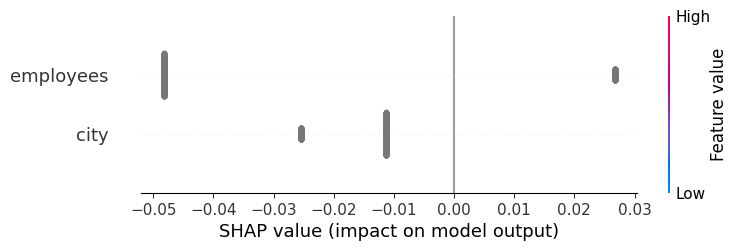

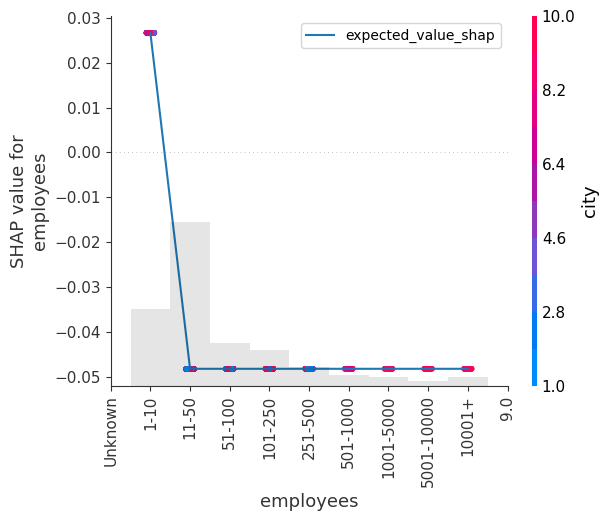

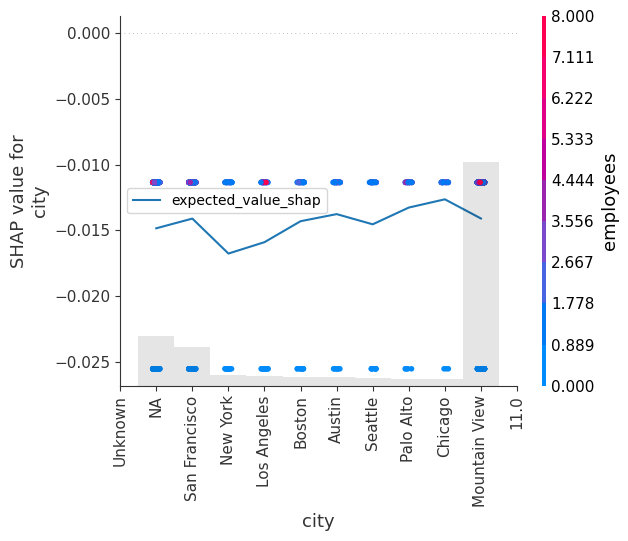

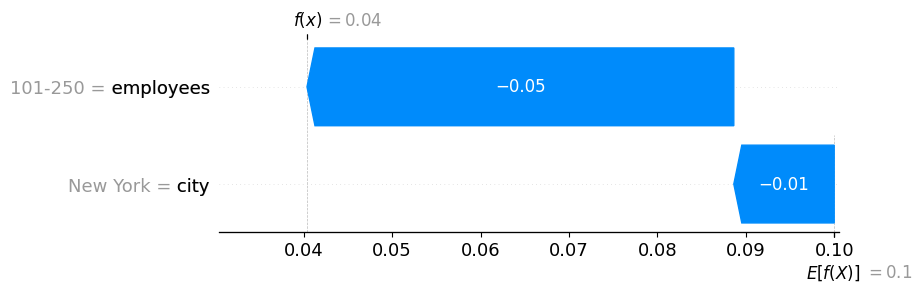

In [21]:
shap.plots.beeswarm(shap_cat)

# individual plots
for var in all_features:

    fig, ax = plt.subplots()

    shap.plots.scatter(shap_obj[:, var], ax=ax, show=False, color=shap_obj)

    # find which transformer has this feature
    trans_idx = 0
    for i, trans in enumerate(mdl[0].transformers_):
        if var in trans[-1]:
            trans_idx = i
            var_idx = trans[-1].index(var)

    # replace labels with orig
    if var not in numeric_features:
        # get integer labels
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        orig_list = ax.get_xticks()
        new_list = np.insert(
            mdl[0].transformers_[trans_idx][1][-1].categories_[var_idx],
            0,
            "Unknown",
        )

        for i in range(len(orig_list) - len(new_list)):
            new_list = np.append(new_list, orig_list[i + len(new_list)])

        # average change
        shap_col_df = pd.DataFrame(
            {
                var: shap_obj[:, var].data,
                "expected_value_shap": (
                    shap_obj[:, var].values  # + shap_cat[:, var].base_values
                ),
            }
        )
        shap_col_grp_df = shap_col_df.groupby(var).mean()
        shap_col_grp_df.plot(ax=ax)

        # rotate as necessary
        ax.set_xticks(orig_list)
        if len(orig_list) > 5:
            ax.set_xticklabels(new_list, rotation=90)
        else:
            ax.set_xticklabels(new_list)

    plt.show()

# sample
shap.plots.waterfall(shap_cat[0])

with open(f"explainer.pkl", "wb") as handle:
    dill.dump(explainer, handle, recurse=True)

mlflow.log_artifact(f"explainer.pkl")

os.remove(f"explainer.pkl")

mlflow.end_run()

## Conclusion 3
 1. based on the simpler model, smallest employees and Chicago/Palo Alto have slightly higher risk vs New York
 1. Some of this may be due to correlation with delisted, so is something to consider

## Predict based on model

In [22]:
df_test["predicted_value"] = mdl.predict(df_test)

test_profit_perco = 9000 - np.average(df_test["predicted_value"]) * 100000

print(f"estimated profit per company is {test_profit_perco}")

estimated profit per company is -1003.8868033662238


## Final Conclusion and Proposed Strategy
 1. Test profit is negative - However, if we either more appropriately charge higher risk
 or stop writing risks > with a level of expected loss (0.1), then we can increase profits
 1. We should also improve dataset by finding status for test set, e.g. by finding tickers
 using website like https://bigpicture.io/docs/api/#name-to-domain-api-beta
 or https://www.klazify.com/category and cross reference with above delisted

In [23]:
#
include_idx = (
    df_test["predicted_value"] < 0.13
)  # selected based on business/growth goals
num_pols = sum(include_idx)
test_profit_filtered = (
    9000 * num_pols - sum(df_test.loc[include_idx, "predicted_value"]) * 100000
)
test_profit_filtered_avg = test_profit_filtered / num_pols

print(f"out of original {df_test.shape[0]} records, included {num_pols}")
print(f"total profit with new strat {test_profit_filtered}")

print(f"avg profit {test_profit_filtered_avg}")

out of original 2000 records, included 1651
total profit with new strat 283160.6031716969
avg profit 171.50854219969526


 The final level of exclusion or rate change should consider - expected new business,
 how confident we are in individual rate change factors, and expected business that is lost

## Addendum
 Streamlit app to understand changes and to iterate on